In [ ]:
#   CISC_882 main file. this file contains all the code to preprocess data, create a CNN model, train the model, test the model, and visualize results
#   Copyright (C) 2024 Catarina Borges McDiarmid, Mide Olanrewaju & Shrinidhi Thatahngudi Sampath Krishnan

#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.

#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.

#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <https://www.gnu.org/licenses/>.

Import required modules

In [1]:
import cv2
import gc
import glob
import itertools
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import patient_data
import pydicom
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-17 23:52:03.012299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 23:52:03.028484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734479523.047465   59257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734479523.053171   59257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 23:52:03.073346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Access the folder path for the cancer and the non-cancer images

In [2]:
all_paths = json.loads(open("./paths.json").read())

personal_path = all_paths['personal_path']
cancerous_path = personal_path + all_paths['cancerous_path']

Configure GPUs is applicable

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) > 0:
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)

Num GPUs Available:  2


Load in all the DICOM files and preprocess/label images

In [4]:
# Using the patient_data data structure, load in all the patient data and save it in a dictionary with the folder name as the key
def load_all_patients(path, add_label = False):
    patients = np.array([])
    folder = os.listdir(path)
    # make shuffling and train/test split here
    for name in folder:
        patients= np.append(patients, patient_data.Patient(path, name, add_label))
        if patients[-1].ct_paths == []:
            print(name, "was not processed correctly")
            patients = patients[:-1]
    return patients

patients = load_all_patients(cancerous_path, True)

.ipynb_checkpoints was not processed correctly


In [5]:
num_nc = 0
num_c = 0
for i in patients:
    num_nc += sum(1 for j in i.labels if j ==0)   
    num_c += sum(1 for j in i.labels if j ==1)  

print("number of patients loaded:", len(patients))
print("number of non-cancerous images in this dataset:", num_nc)
print("number of cancerous images in this dataset:", num_c)

number of patients loaded: 422
number of non-cancerous images in this dataset: 46726
number of cancerous images in this dataset: 7610


Setting up train/test data

In [6]:
# mix up the data
patients = shuffle(patients)

# Train-test split should be 80-20. 
# Since the data has been shuffled, we can just grab the 1st 80% of the list and make it the train set and the remainder is the test set
train_patients = patients[:math.floor(len(patients) * 0.8)]
test_patients = patients[math.floor(len(patients) * 0.8):]

def save_imgs(dest, list_paths, list_labels):
    cancerous_img_folder = dest + "/cancerous"
    non_cancerous_img_folder = dest + "/non_cancerous"
    if not os.path.exists(cancerous_img_folder):
        os.makedirs(cancerous_img_folder)
    if not os.path.exists(non_cancerous_img_folder):
        os.makedirs(non_cancerous_img_folder)
    # for our purposes, we know we dont want these folders to have any previous content, so remove anything in here if there is something
    for file in glob.glob(cancerous_img_folder + "/*"):
        os.remove(file)
    for file in glob.glob(non_cancerous_img_folder + "/*"):
        os.remove(file)
    # save images
    for i, dicom_path in enumerate(list_paths):
        if list_labels[i] == 0:
            img_folder = non_cancerous_img_folder
        else:
            img_folder = cancerous_img_folder
        dicom = pydicom.dcmread(dicom_path)
        pix_array = dicom.pixel_array
        img = cv2.normalize(pix_array, None, 0, 255, cv2.NORM_MINMAX)
        cv2.imwrite(f"{img_folder}/image_{i}.jpg", img)

train_dest = personal_path + "/train/train"
val_dest = personal_path + "/train/validation"
test_dest = personal_path + "/test"


# save_imgs(train_dest, train_patients)
x_test, y_test = [], []
for patient in test_patients:
    x_test.extend(patient.ct_paths)
    y_test.extend(patient.labels)
save_imgs(test_dest, x_test, y_test)
test_ds = ImageDataGenerator().flow_from_directory(
        directory=test_dest, # the path to the test directory.
        target_size=(512, 512),
        batch_size=32,
        class_mode="binary",
        shuffle = False
    )

del test_patients
del patients

Found 10485 images belonging to 2 classes.


Create a custom callback to clear any memory that is no longer being used

In [7]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect
        tf.keras.backend.clear_session()

Confusion matrix to visualize results from each fold

In [8]:
# code to plot confusion matrix, taken from scikit-learn's website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


Training fold 1/5
amount of train images in this fold: 9972
amount of validation images in this fold: 8149


I0000 00:00:1734479635.963179   59257 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
I0000 00:00:1734479635.964720   59257 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43598 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:ca:00.0, compute capability: 8.6


Found 9972 images belonging to 2 classes.
Found 8149 images belonging to 2 classes.
Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)
I0000 00:00:1734479663.219629   59795 service.cc:148] XLA service 0x7fef900017b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734479663.219655   59795 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
I0000 00:00:1734479663.219659   59795 service.cc:15

624/624 ━━━━━━━━━━━━━━━━━━━━ 233s 298ms/step - accuracy: 0.8393 - loss: 0.4390 - val_accuracy: 0.8354 - val_loss: 0.4026 - learning_rate: 1.0000e-05
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 162s 259ms/step - accuracy: 0.9677 - loss: 0.0900 - val_accuracy: 0.8320 - val_loss: 0.4575 - learning_rate: 1.0000e-05
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 162s 260ms/step - accuracy: 0.9886 - loss: 0.0346 - val_accuracy: 0.8392 - val_loss: 0.5680 - learning_rate: 1.0000e-05
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 162s 259ms/step - accuracy: 0.9922 - loss: 0.0230 - val_accuracy: 0.8507 - val_loss: 0.5554 - learning_rate: 1.0000e-05
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 162s 260ms/step - accuracy: 0.9957 - loss: 0.0120 - val_accuracy: 0.8137 - val_loss: 0.8500 - learning_rate: 5.0000e-06
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 162s 259ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.8438 - val_loss: 0.6787 - learning_rate: 5.0000e-06


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


328/328 ━━━━━━━━━━━━━━━━━━━━ 59s 162ms/step
              precision    recall  f1-score   support

           0       0.47      0.66      0.55      1435
           1       0.94      0.88      0.91      9050

    accuracy                           0.85     10485
   macro avg       0.71      0.77      0.73     10485
weighted avg       0.88      0.85      0.86     10485

Confusion matrix, without normalization
[[ 944  491]
 [1046 8004]]

Training fold 2/5
amount of train images in this fold: 9944
amount of validation images in this fold: 9161
Found 9944 images belonging to 2 classes.
Found 9161 images belonging to 2 classes.
Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


622/622 ━━━━━━━━━━━━━━━━━━━━ 230s 309ms/step - accuracy: 0.8277 - loss: 0.4418 - val_accuracy: 0.8717 - val_loss: 0.3549 - learning_rate: 1.0000e-05
Epoch 2/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 166s 267ms/step - accuracy: 0.9578 - loss: 0.1031 - val_accuracy: 0.8422 - val_loss: 0.4650 - learning_rate: 1.0000e-05
Epoch 3/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9874 - loss: 0.0412 - val_accuracy: 0.8581 - val_loss: 0.4344 - learning_rate: 1.0000e-05
Epoch 4/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9958 - loss: 0.0170 - val_accuracy: 0.8565 - val_loss: 0.4998 - learning_rate: 1.0000e-05
Epoch 5/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.9978 - loss: 0.0103 - val_accuracy: 0.8561 - val_loss: 0.5634 - learning_rate: 5.0000e-06
Epoch 6/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8565 - val_loss: 0.5932 - learning_rate: 5.0000e-06


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


328/328 ━━━━━━━━━━━━━━━━━━━━ 54s 157ms/step
              precision    recall  f1-score   support

           0       0.50      0.38      0.43      1435
           1       0.91      0.94      0.92      9050

    accuracy                           0.86     10485
   macro avg       0.70      0.66      0.68     10485
weighted avg       0.85      0.86      0.85     10485

Confusion matrix, without normalization
[[ 548  887]
 [ 557 8493]]

Training fold 3/5
amount of train images in this fold: 9956
amount of validation images in this fold: 9229
Found 9956 images belonging to 2 classes.
Found 9229 images belonging to 2 classes.
Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


623/623 ━━━━━━━━━━━━━━━━━━━━ 227s 302ms/step - accuracy: 0.8060 - loss: 0.4793 - val_accuracy: 0.8609 - val_loss: 0.3603 - learning_rate: 1.0000e-05
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.9567 - loss: 0.1107 - val_accuracy: 0.8643 - val_loss: 0.3560 - learning_rate: 1.0000e-05
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9914 - loss: 0.0293 - val_accuracy: 0.8578 - val_loss: 0.4835 - learning_rate: 1.0000e-05
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9941 - loss: 0.0196 - val_accuracy: 0.8540 - val_loss: 0.4486 - learning_rate: 1.0000e-05
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.9879 - loss: 0.0320 - val_accuracy: 0.8721 - val_loss: 0.4973 - learning_rate: 1.0000e-05
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9969 - loss: 0.0097 - val_accuracy: 0.8543 - val_loss: 0.5698 - learning_rate: 5.0000e-06
Epoch 7/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/

/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


328/328 ━━━━━━━━━━━━━━━━━━━━ 52s 151ms/step
              precision    recall  f1-score   support

           0       0.47      0.67      0.55      1435
           1       0.94      0.88      0.91      9050

    accuracy                           0.85     10485
   macro avg       0.71      0.77      0.73     10485
weighted avg       0.88      0.85      0.86     10485

Confusion matrix, without normalization
[[ 955  480]
 [1081 7969]]

Training fold 4/5
amount of train images in this fold: 9686
amount of validation images in this fold: 8767
Found 9686 images belonging to 2 classes.
Found 8767 images belonging to 2 classes.
Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


606/606 ━━━━━━━━━━━━━━━━━━━━ 225s 309ms/step - accuracy: 0.8287 - loss: 0.4343 - val_accuracy: 0.8426 - val_loss: 0.4118 - learning_rate: 1.0000e-05
Epoch 2/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 162s 267ms/step - accuracy: 0.9566 - loss: 0.1187 - val_accuracy: 0.8263 - val_loss: 0.5852 - learning_rate: 1.0000e-05
Epoch 3/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 162s 268ms/step - accuracy: 0.9872 - loss: 0.0425 - val_accuracy: 0.8384 - val_loss: 0.6481 - learning_rate: 1.0000e-05
Epoch 4/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 162s 267ms/step - accuracy: 0.9966 - loss: 0.0155 - val_accuracy: 0.8448 - val_loss: 0.7195 - learning_rate: 1.0000e-05
Epoch 5/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 163s 268ms/step - accuracy: 0.9982 - loss: 0.0073 - val_accuracy: 0.8255 - val_loss: 0.7850 - learning_rate: 5.0000e-06
Epoch 6/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 163s 269ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.8239 - val_loss: 0.8729 - learning_rate: 5.0000e-06


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 153ms/step
              precision    recall  f1-score   support

           0       0.48      0.60      0.53      1435
           1       0.93      0.90      0.92      9050

    accuracy                           0.86     10485
   macro avg       0.71      0.75      0.72     10485
weighted avg       0.87      0.86      0.86     10485

Confusion matrix, without normalization
[[ 855  580]
 [ 924 8126]]

Training fold 5/5
amount of train images in this fold: 9842
amount of validation images in this fold: 8545
Found 9842 images belonging to 2 classes.
Found 8545 images belonging to 2 classes.
Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


616/616 ━━━━━━━━━━━━━━━━━━━━ 223s 301ms/step - accuracy: 0.8333 - loss: 0.4361 - val_accuracy: 0.8680 - val_loss: 0.3040 - learning_rate: 1.0000e-05
Epoch 2/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 163s 264ms/step - accuracy: 0.9692 - loss: 0.0893 - val_accuracy: 0.8459 - val_loss: 0.4461 - learning_rate: 1.0000e-05
Epoch 3/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 163s 264ms/step - accuracy: 0.9900 - loss: 0.0293 - val_accuracy: 0.8591 - val_loss: 0.4692 - learning_rate: 1.0000e-05
Epoch 4/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 163s 264ms/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 0.8516 - val_loss: 0.5385 - learning_rate: 1.0000e-05
Epoch 5/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 163s 265ms/step - accuracy: 0.9985 - loss: 0.0073 - val_accuracy: 0.8640 - val_loss: 0.5341 - learning_rate: 5.0000e-06
Epoch 6/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 163s 264ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.8552 - val_loss: 0.5712 - learning_rate: 5.0000e-06


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1435
           1       0.92      0.92      0.92      9050

    accuracy                           0.87     10485
   macro avg       0.72      0.71      0.71     10485
weighted avg       0.87      0.87      0.87     10485

Confusion matrix, without normalization
[[ 725  710]
 [ 697 8353]]

Average Accuracy Across 5 Folds: 0.8578


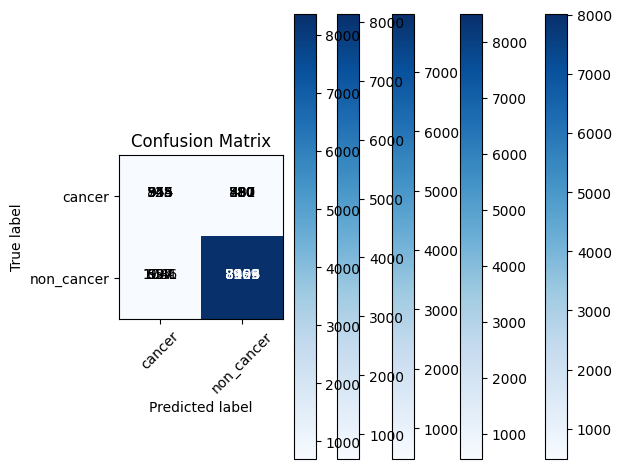

In [9]:
# Define K-Fold Cross-Validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = []

# we want to separate validation from train set by patient, nit just image
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_patients, [0]*len(train_patients))):
    print(f"\nTraining fold {fold + 1}/{n_splits}")
    
    # split the train patients up into cancer pos and cancer neg image paths and labels
    x_train_pos, x_train_neg, y_train_pos, y_train_neg = [], [], [], []
    for patient in train_patients[train_idx]:
        for i, label in enumerate(patient.labels):
            if label == 0:
                x_train_neg.append(patient.ct_paths[i])
                y_train_neg.append(label)
            else:
                x_train_pos.append(patient.ct_paths[i])
                y_train_pos.append(label)
    # shuffle paths together with labels (even though the labels should all be the same in each group at this point)
    x_train_neg, y_train_neg = shuffle(x_train_neg, y_train_neg)
    x_train_pos, y_train_pos = shuffle(x_train_pos, y_train_pos)
    # amount of non-cancer images to keep to maintain balance in training dataset
    keep = len(x_train_pos)
    # since the non-cancerous set has been shuffled, we can splice the set at the length of the cancerous dataset and we will have a random amount of images from each patient in the set 
    x_train = []
    x_train.extend(x_train_pos)
    x_train.extend(x_train_neg[:keep])
    y_train = []
    y_train.extend(y_train_pos)
    y_train.extend(y_train_neg[:keep])
    # convert lists to arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    # shuffle again to make sure pos/neg have been mixed 
    x_train, y_train = shuffle(x_train, y_train)
    print("amount of train images in this fold:", len(x_train))
    
    # new list for validation set
    x_val, y_val = [], []
    for patient in train_patients[val_idx]:
        # no need to make pos/neg separation for this set
        x_val.extend(patient.ct_paths)
        y_val.extend(patient.labels)
    # turn lists into arrays
    x_val, y_val = np.array(x_val), np.array(y_val)
    # shuffle arrays
    x_val, y_val = shuffle(x_val, y_val)
    print("amount of validation images in this fold:", len(x_val))

    save_imgs(train_dest, x_train, y_train)
    save_imgs(val_dest, x_val, y_val)   
        
    # Load the ResNet50 model pre-trained on ImageNet
    model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(512, 512, 3)))
    
    # Custom layers
    flattened = tf.keras.layers.Flatten()(model.output)
    l2 = tf.keras.layers.Dense(128, activation='relu')(flattened)
    l3 = tf.keras.layers.Dense(1, activation='sigmoid')(l2)
    
    # Define the full model
    model = tf.keras.models.Model(inputs=model.input, outputs=l3)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Use a smaller learning rate for end-to-end training
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # since we have saved all images from the dicoms as jpgs, we can use the ImageDataGenerator to generate our datasets
    train_ds = ImageDataGenerator().flow_from_directory(
            directory=train_dest, # the path to the training directory.
            target_size=(512, 512),
            batch_size=16,
            class_mode="binary",
        )
    
    val_ds = ImageDataGenerator().flow_from_directory(
            directory=val_dest, # the path to the validation directory.
            target_size=(512, 512),
            batch_size=16,
            class_mode="binary",
        )

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)
    
    # Train the model directly using the training and validation data
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # Evaluate the model using the test dataset we made earlier
    predictions = (model.predict(test_ds) > 0.5).astype("int32")
    report = classification_report(test_ds.classes, predictions, output_dict=True)
    print(classification_report(test_ds.classes, predictions))

    cm = confusion_matrix(y_true=test_ds.classes, y_pred=predictions)
    cm_plot_labels = ['cancer','non_cancer']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
    
    # Save fold results
    fold_results.append(report)
    K.clear_session()

# Aggregate results
avg_accuracy = np.mean([fold['accuracy'] for fold in fold_results])
print(f"\nAverage Accuracy Across {n_splits} Folds: {avg_accuracy:.4f}")


Confusion matrix, without normalization
[[ 725  710]
 [ 697 8353]]


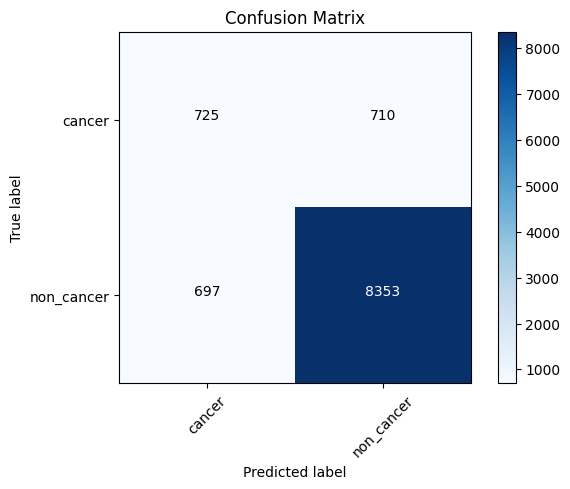

In [10]:
cm = confusion_matrix(y_true=test_ds.classes, y_pred=predictions)
cm_plot_labels = ['cancer','non_cancer']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')